## Introduction Examples

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.utils.random import sample_without_replacement
from imblearn.under_sampling import RandomUnderSampler

N = 100000
X, y = make_blobs(n_samples=N, n_features=2, centers=[[0, 0]], cluster_std=3, random_state=2)
mins = X.min(axis=0)
maxs = X.max(axis=0)

def add_noise(X, y):
  X2 = np.random.rand(int(N * 0.2), 2)
  y2 = np.full(int(N * 0.2), -1)
  X2[:, 0] = (X2[:, 0] * (maxs[0] - mins[0])) + mins[0]
  X2[:, 1] = (X2[:, 1]) * (maxs[1] - mins[1]) + mins[1]

  X_ = np.concatenate([X, X2], axis=0)
  y_ = np.concatenate([y, y2], axis=0)
  return X_, y_

X, y = add_noise(X, y)


def cluster(X, y):
  clustering = DBSCAN(eps=0.32, min_samples=100).fit(X)
  c = clustering.labels_
  return c


def to_df(X, y):
  df = pd.DataFrame(X, columns=["A, B"])
  df["y"] = y
  return df


def draw_uniform_sample(X, y, n_sample: int):
  # shuffle the input data
  random = np.random.rand(len(X))
  random_order = np.argsort(random)
  X_ = X[random_order]

  # draw random sample
  sample = sample_without_replacement(n_population=len(X_), n_samples=n_sample, random_state=0)

  return to_df(X[sample], y[sample])


def draw_inlier_sample(X, y, n_sample: int):
  # dbscan: -1 is outlier, so inlier is > -1
  c = cluster(X, y)
  c = (c > -1).astype(int)

  # in case there are more than n_sample inliers, sample down uniformly
  return draw_uniform_sample(X[c == 1], c[c == 1], n_sample=n_sample)


def draw_stratified_sample(X, y, n_sample: int):
  c = cluster(X, y)
  c = (c > -1).astype(int)
  
  # clustering might find more than 2 clusters, but all we need is inlier/outliere(int)

  rus = RandomUnderSampler()
  X_, y_ = rus.fit_resample(X, c)
  return draw_uniform_sample(X_, y_, n_sample=n_sample)


def draw_noise_sample(X, y, n_sample: int):
  c = cluster(X, y)
  c = (c > -1).astype(int)
  
  return draw_uniform_sample(X[y == -1], c[y == -1], n_sample)


def draw_outlier_sample(X, y, n_sample: int):
  # dbscan: -1 is outlier, so inlier is > -1
  c = cluster(X, y).astype(int)

  return draw_uniform_sample(X[c == -1], c[c == -1], n_sample)

### Plot full dataset

(-12.48393401358247, 14.190341438793237)

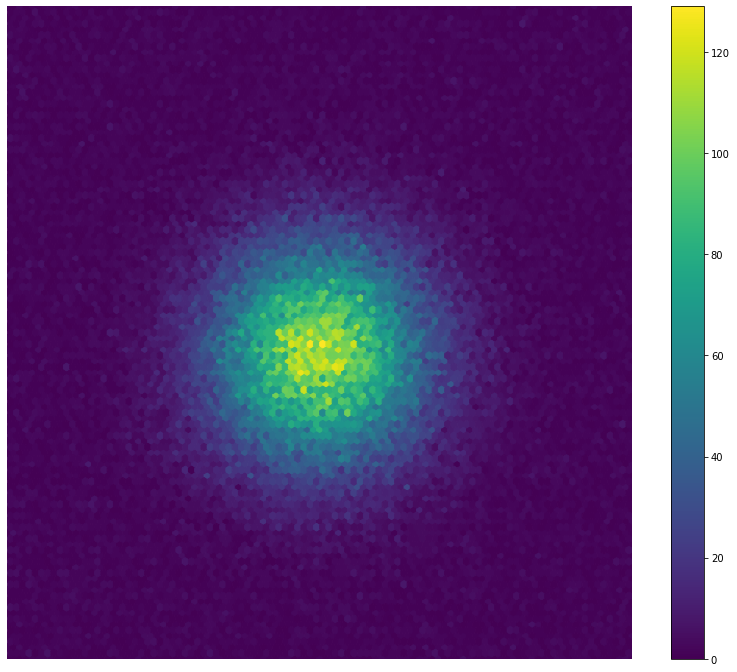

In [4]:
df = pd.DataFrame(X, columns=["A, B"])
plt = df.plot.hexbin(
  x='A',
  y='B',
  reduce_C_function=np.sum,
  gridsize=100,
  cmap="viridis",
  figsize=[14, 12],
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

### Plot different sampling tasks on that dataset

(-12.48393401358247, 14.190341438793237)

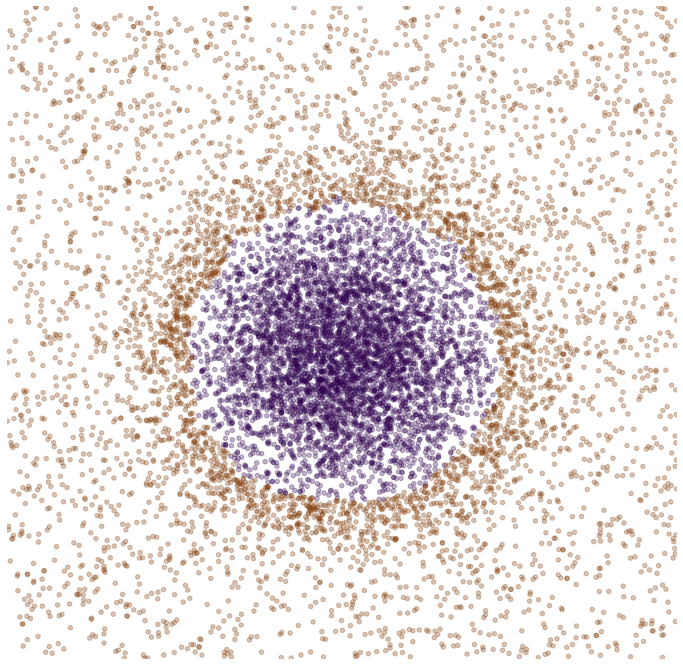

In [3]:
# plot a sampling
# df = draw_noise_sample(X, y, 10000)
df = draw_stratified_sample(X, y, 10000)
# df = draw_outlier_sample(X, y, 10000)
# df = draw_inlier_sample(X, y, 10000)
# df = draw_uniform_sample(X, y, 10000)

plt = df.plot.scatter(
  x="A", 
  y="B", 
  # c="#2f124b", 
  c="y",
  colormap="PuOr", 
  alpha=0.3, 
  figsize=[12, 12], 
  colorbar=False,
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

## Use Case Examples

### Effect of three pipelines on value distributions

Below, we demonstrate how tailoring linearization and subdivision steps of the pipeline towards particular attributes allows tailoring the sampling towards different user interests.

The pipelines:

In [24]:
import os, sys
sys.path.append(f"{os.getcwd()}/../")

from pipeline.Pipeline import Pipeline

# focus on spatial attributes
config1 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "standard",
  "selection": "random",
  "dimension": 5,
  "params": {}
}

# focus on numerical attributes
config2 = {
  "data": "taxis",
  "linearization": "numeric",
  "subdivision": "standard",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [5]  # trip distance
  }
}

# focus on temporal attribute
config3 = {
  "data": "taxis",
  "linearization": "temporal",
  "subdivision": "stratified",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [2, 3]  # pickup and dropoff time
  }
}

pl1 = Pipeline(config1)
pl2 = Pipeline(config2)
pl3 = Pipeline(config3)

preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing


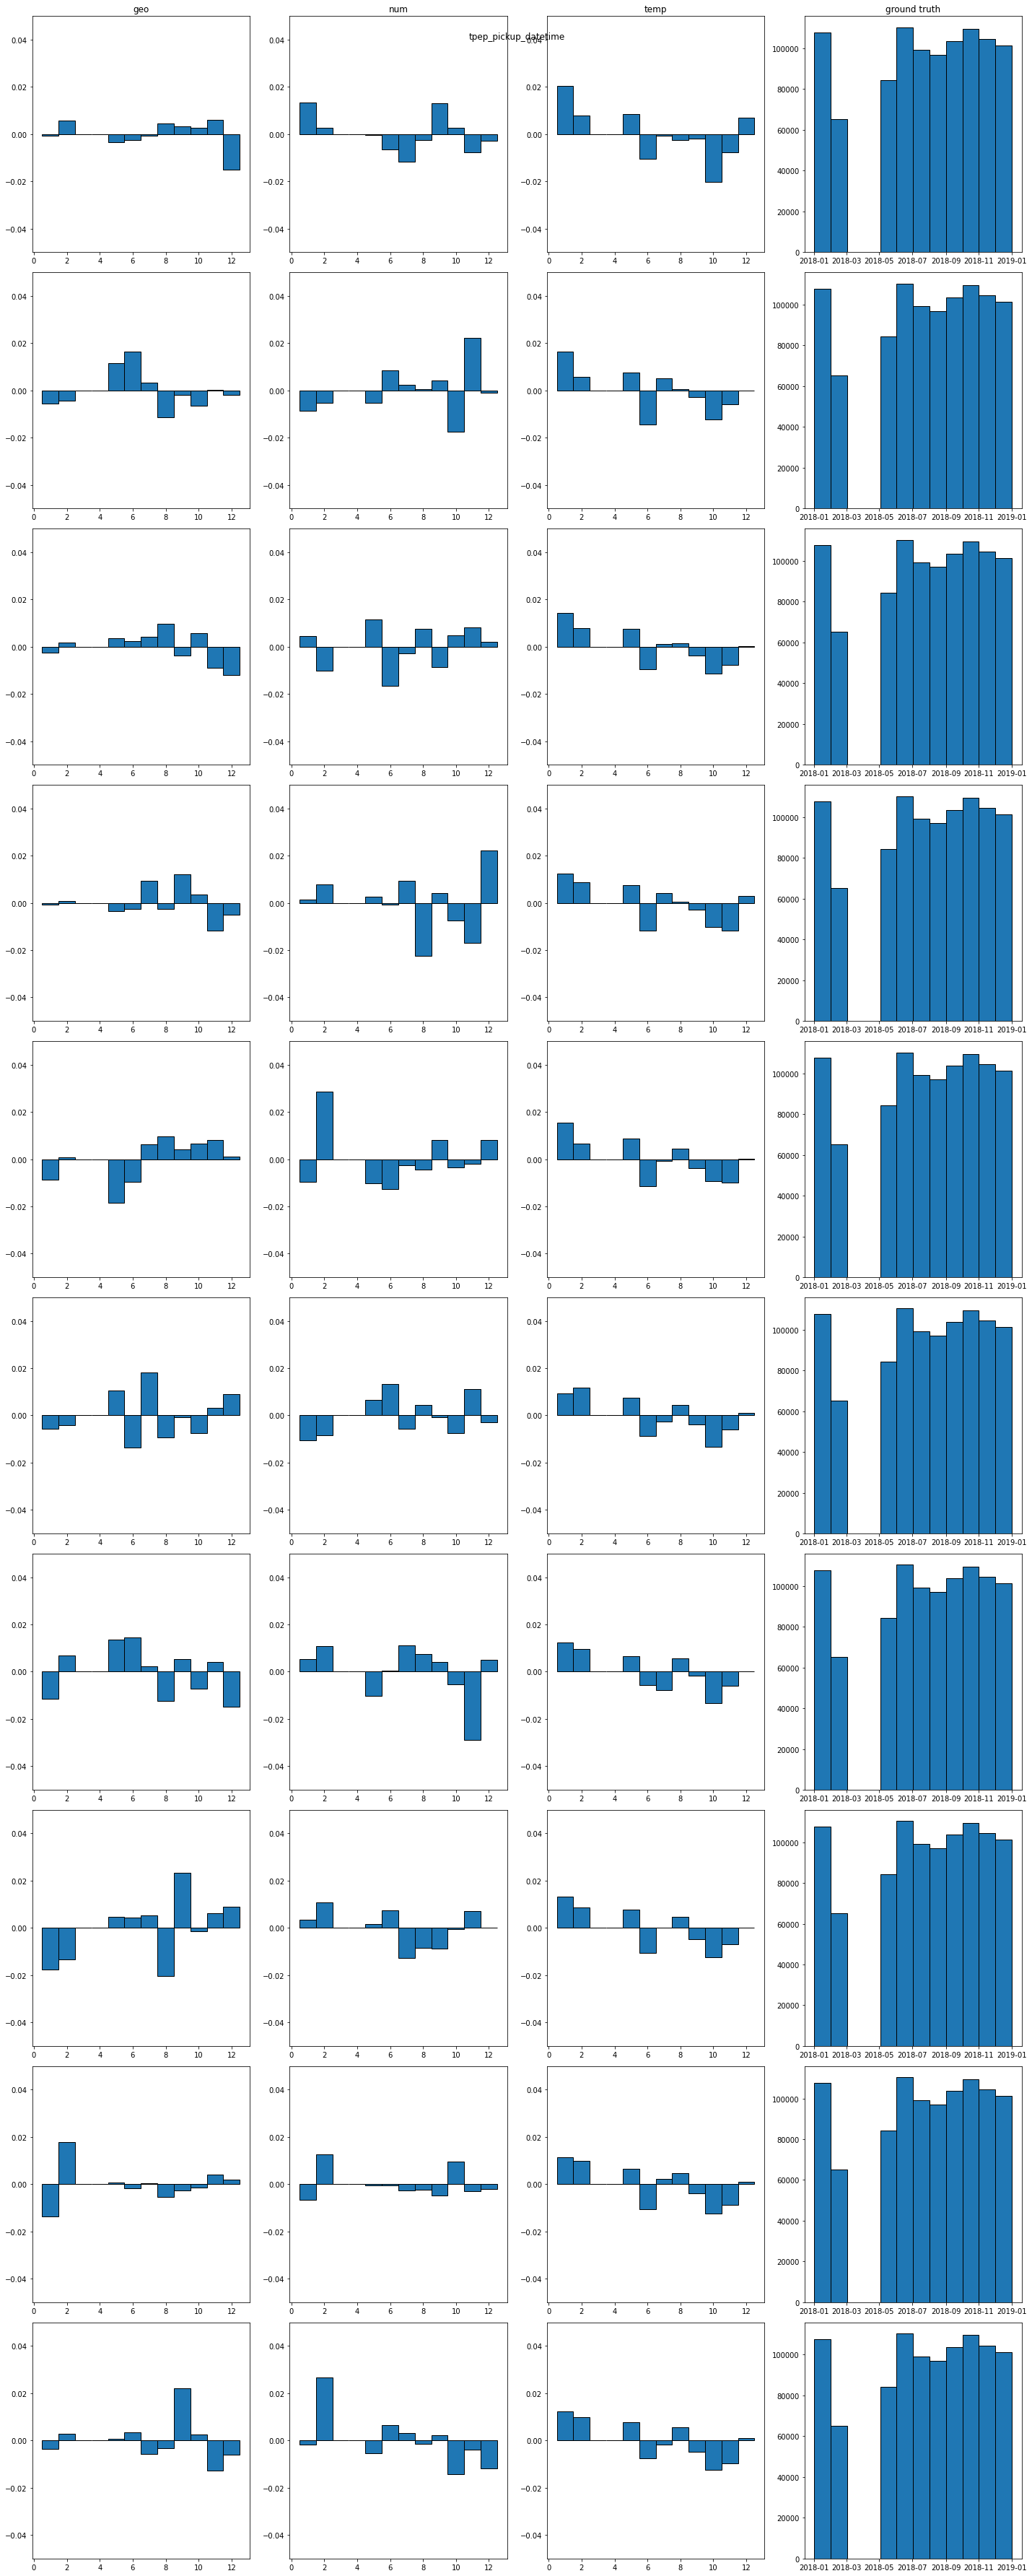

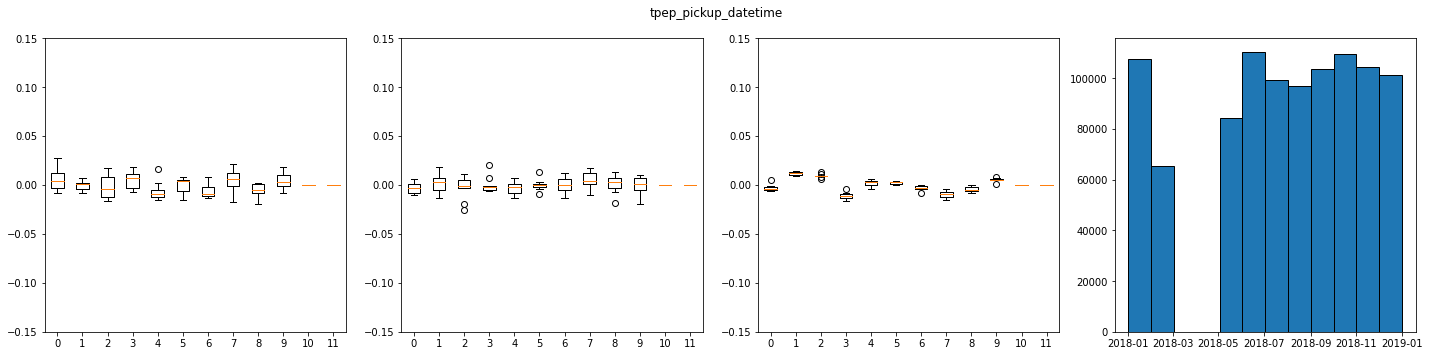

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def hist(sample_df: pd.Series, value_range: tuple, n_bins, ax: plt):
  return ax.hist(
    sample_df, 
    bins=n_bins,
    range=value_range,
    edgecolor='black', 
    linewidth=1
  )

def delta_hist(delta: pd.Series, ax: plt):
  return ax.bar(
    delta.index,
    delta,
    width=1,
    edgecolor='black', 
    linewidth=1,
  )

def delta_boxplot(delta: pd.Series, ax: plt):
  # print(delta)
  return ax.boxplot(
    delta,
    labels=delta.columns
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]


def plot_time_hist(attr: str):
  fig, ax = plt.subplots(n_chunks, 4, figsize=(20, n_chunks * 5))
  fig.suptitle(attr)
  date_range = ("2018-01-01 00:00:00", "2018-12-31 23:59:59")

  ground_truth_df = pd.to_datetime(pd.DataFrame(pl1.subdivision.linearization, columns=columns)[attr])
  gt_monthly_dist = ground_truth_df.dt.month.value_counts(normalize=True).sort_index()

  for i in range(n_chunks):
    chunk_geo = pd.to_datetime(pd.DataFrame(pl1.get_next_chunk(), columns=columns)[attr])
    chunk_num = pd.to_datetime(pd.DataFrame(pl2.get_next_chunk(), columns=columns)[attr])
    chunk_temp = pd.to_datetime(pd.DataFrame(pl3.get_next_chunk(), columns=columns)[attr])

    for j, df in enumerate([chunk_geo, chunk_num, chunk_temp]):
      monthly_dist = df.dt.month.value_counts(normalize=True).sort_index()

      delta = monthly_dist - gt_monthly_dist
      for k in range(1, 13):
        delta.loc[k] = delta.loc[k] if k in delta.index else 0

      ax[i][j].set_ylim(-0.05, 0.05)
      delta_hist(delta, ax[i][j])

    hist(ground_truth_df, date_range, 12, ax[i][3])

  for ax_, col in zip(ax[0], ["geo", "num", "temp", "ground truth"]):
    ax_.set_title(col)
  
  plt.tight_layout()
  plt.show()


def boxplot_time_summary(attr: str):
  fig, ax = plt.subplots(1, 4, figsize=(20, 5))
  fig.suptitle(attr)
  date_range = ("2018-01-01 00:00:00", "2018-12-31 23:59:59")

  ground_truth_df = pd.to_datetime(pd.DataFrame(pl1.subdivision.linearization, columns=columns)[attr])
  gt_monthly_dist = ground_truth_df.dt.month.value_counts(normalize=True).sort_index()

  delta_geo = pd.DataFrame()
  delta_num = pd.DataFrame()
  delta_temp = pd.DataFrame()
  delta_dfs = [delta_geo, delta_num, delta_temp]

  for i in range(n_chunks):
    chunk_geo = pd.to_datetime(pd.DataFrame(pl1.get_next_chunk(), columns=columns)[attr])
    chunk_num = pd.to_datetime(pd.DataFrame(pl2.get_next_chunk(), columns=columns)[attr])
    chunk_temp = pd.to_datetime(pd.DataFrame(pl3.get_next_chunk(), columns=columns)[attr])

    for j, df in enumerate([chunk_geo, chunk_num, chunk_temp]):
      monthly_dist = df.dt.month.value_counts(normalize=True).sort_index()

      delta = monthly_dist - gt_monthly_dist
      for k in range(1, 13):
        delta.loc[k] = delta.loc[k] if k in delta.index else 0
      
      delta_dfs[j] = pd.concat([delta_dfs[j], pd.DataFrame(delta.to_numpy().reshape(1, -1))], ignore_index=True)

  hist(ground_truth_df, date_range, 12, ax[3])
  
  for i, df in enumerate(delta_dfs):
    delta_boxplot(df, ax[i])
    ax[i].set_ylim(-0.15, 0.15)

  plt.tight_layout()
  plt.show()


n_chunks = 10
plot_time_hist("tpep_pickup_datetime")
boxplot_time_summary("tpep_pickup_datetime")

A conclusion from the above is that simply linearizing by a temporal dimension does not necessarily produce better results. 
In fact, the mean/median error between the three pipelines is more or less the same. 
What we observe instead is that the per-bin error of the `temp` case is consistent between chunks, while the distribution from the other two pipelines fluctuates.

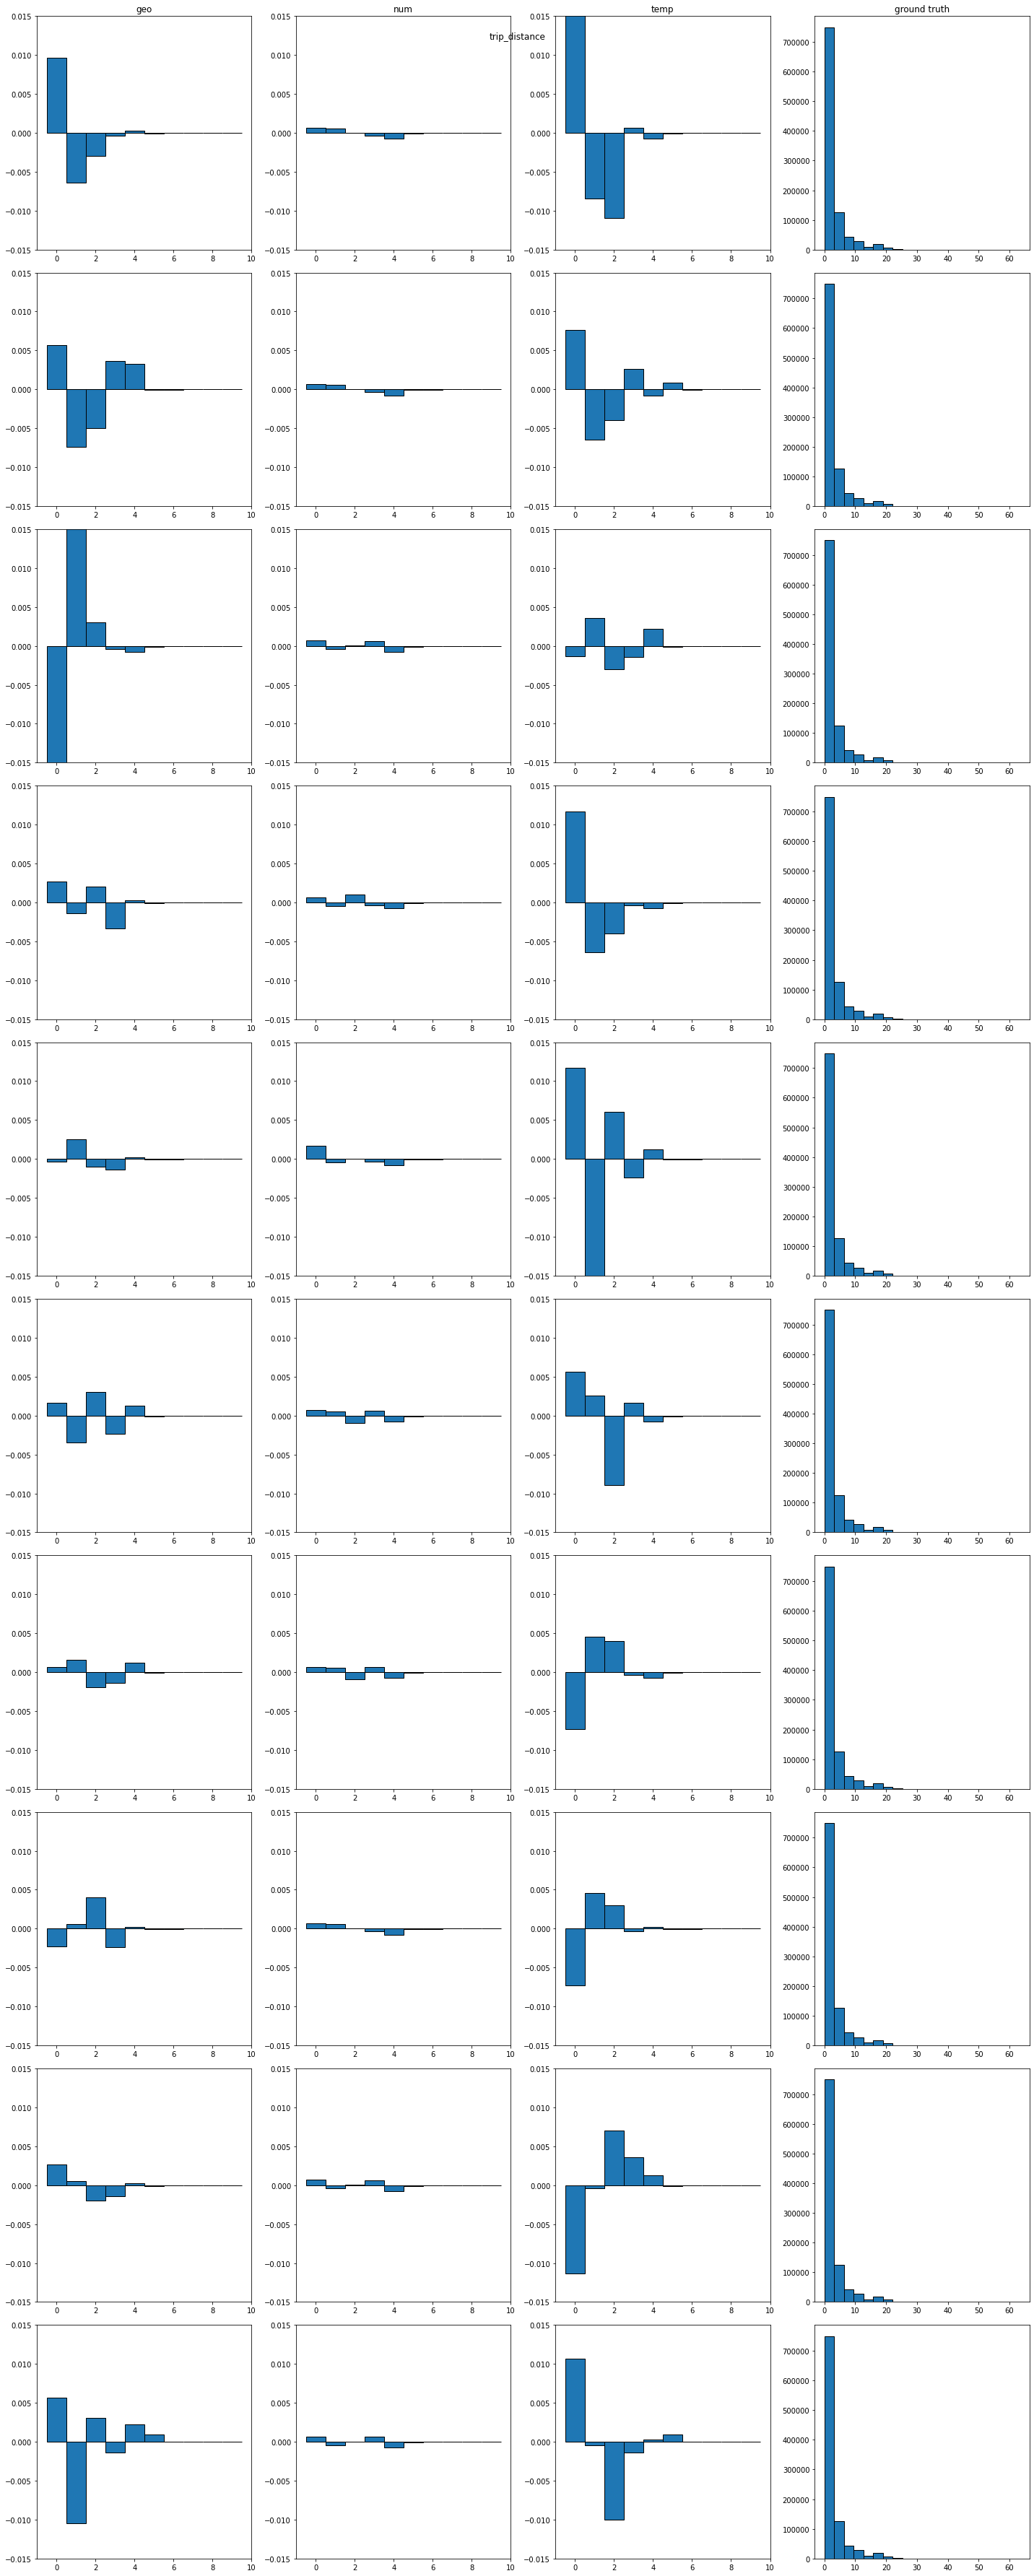

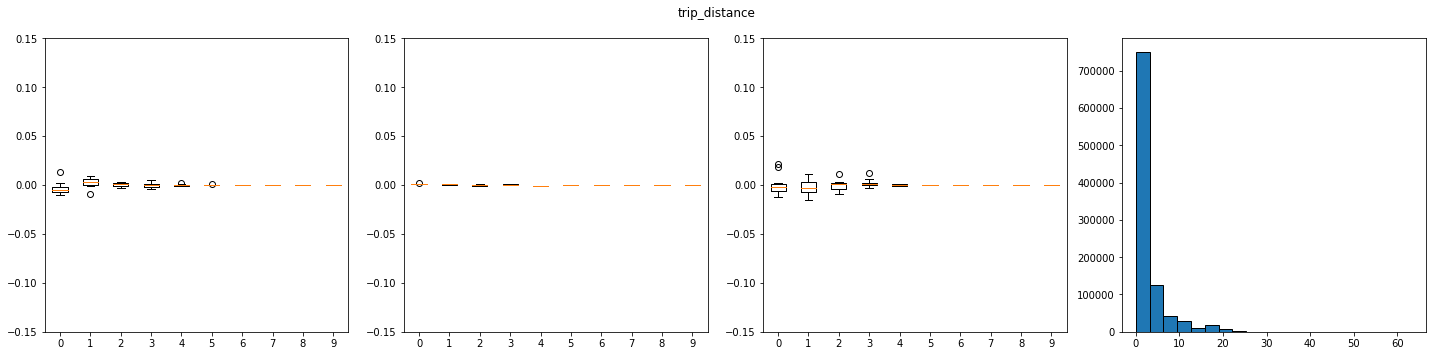

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def scatter(df: pd.DataFrame, range: list[int], ax: plt):
  return ax.scatter(
    x=df[df.columns[0]],
    y=df[df.columns[1]],
  )

def hist(sample_df: pd.Series, value_range: tuple, n_bins, ax: plt):
  return ax.hist(
    sample_df, 
    bins=n_bins,
    range=value_range,
    edgecolor='black', 
    linewidth=1
  )

def delta_hist(delta: pd.Series, ax: plt):
  return ax.bar(
    delta.index,
    delta,
    width=1,
    edgecolor='black', 
    linewidth=1,
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]


def plot_hist(attr: str):
  fig, ax = plt.subplots(n_chunks, 4, figsize=(20, n_chunks * 5))
  fig.suptitle(attr)

  n_bins = 10
  ground_truth_df = pd.DataFrame(pl1.subdivision.linearization, columns=columns)[attr]
  bins = np.linspace(ground_truth_df.min(), ground_truth_df.max(), n_bins+1)  # because arange does not include max

  gt_hist = np.histogram(ground_truth_df, bins=bins)
  gt_bins = gt_hist[0]
  gt_bins = gt_bins / gt_bins.sum()
  value_range = [ground_truth_df.min(), ground_truth_df.max()]

  for i in range(n_chunks):
    chunk_geo = pd.DataFrame(pl1.get_next_chunk(), columns=columns)[attr]
    chunk_num = pd.DataFrame(pl2.get_next_chunk(), columns=columns)[attr]
    chunk_temp = pd.DataFrame(pl3.get_next_chunk(), columns=columns)[attr]

    for j, df in enumerate([chunk_geo, chunk_num, chunk_temp]):
      df_bins = np.histogram(df, bins=bins)[0]
      df_bins = df_bins / df_bins.sum()

      delta_bins = df_bins - gt_bins
      ax[i][j].set_ylim(-0.015, 0.015)
      delta_hist(pd.Series(delta_bins), ax[i][j])

    hist(ground_truth_df, value_range, n_bins*2, ax[i][3])

  for ax_, col in zip(ax[0], ["geo", "num", "temp", "ground truth"]):
    ax_.set_title(col)
  
  plt.tight_layout()
  plt.show()

def boxplot_summary(attr: str):
  fig, ax = plt.subplots(1, 4, figsize=(20, 5))
  fig.suptitle(attr)

  n_bins = 10
  ground_truth_df = pd.DataFrame(pl1.subdivision.linearization, columns=columns)[attr]
  bins = np.linspace(ground_truth_df.min(), ground_truth_df.max(), n_bins+1)  # because arange does not include max

  gt_hist = np.histogram(ground_truth_df, bins=bins)
  gt_bins = gt_hist[0]
  gt_bins = gt_bins / gt_bins.sum()
  value_range = [ground_truth_df.min(), ground_truth_df.max()]

  delta_geo = pd.DataFrame()
  delta_num = pd.DataFrame()
  delta_temp = pd.DataFrame()
  delta_dfs = [delta_geo, delta_num, delta_temp]

  for i in range(n_chunks):
    chunk_geo = pd.DataFrame(pl1.get_next_chunk(), columns=columns)[attr]
    chunk_num = pd.DataFrame(pl2.get_next_chunk(), columns=columns)[attr]
    chunk_temp = pd.DataFrame(pl3.get_next_chunk(), columns=columns)[attr]

    for j, df in enumerate([chunk_geo, chunk_num, chunk_temp]):
      df_bins = np.histogram(df, bins=bins)[0]
      df_bins = df_bins / df_bins.sum()

      delta_bins = df_bins - gt_bins
      
      delta_dfs[j] = pd.concat([delta_dfs[j], pd.DataFrame(delta_bins.reshape(1, -1))], ignore_index=True)

  hist(ground_truth_df, value_range, n_bins * 2, ax[3])
  
  for i, df in enumerate(delta_dfs):
    delta_boxplot(df, ax[i])
    ax[i].set_ylim(-0.15, 0.15)

  plt.tight_layout()
  plt.show()

n_chunks = 10
plot_hist("trip_distance")
boxplot_summary("trip_distance")

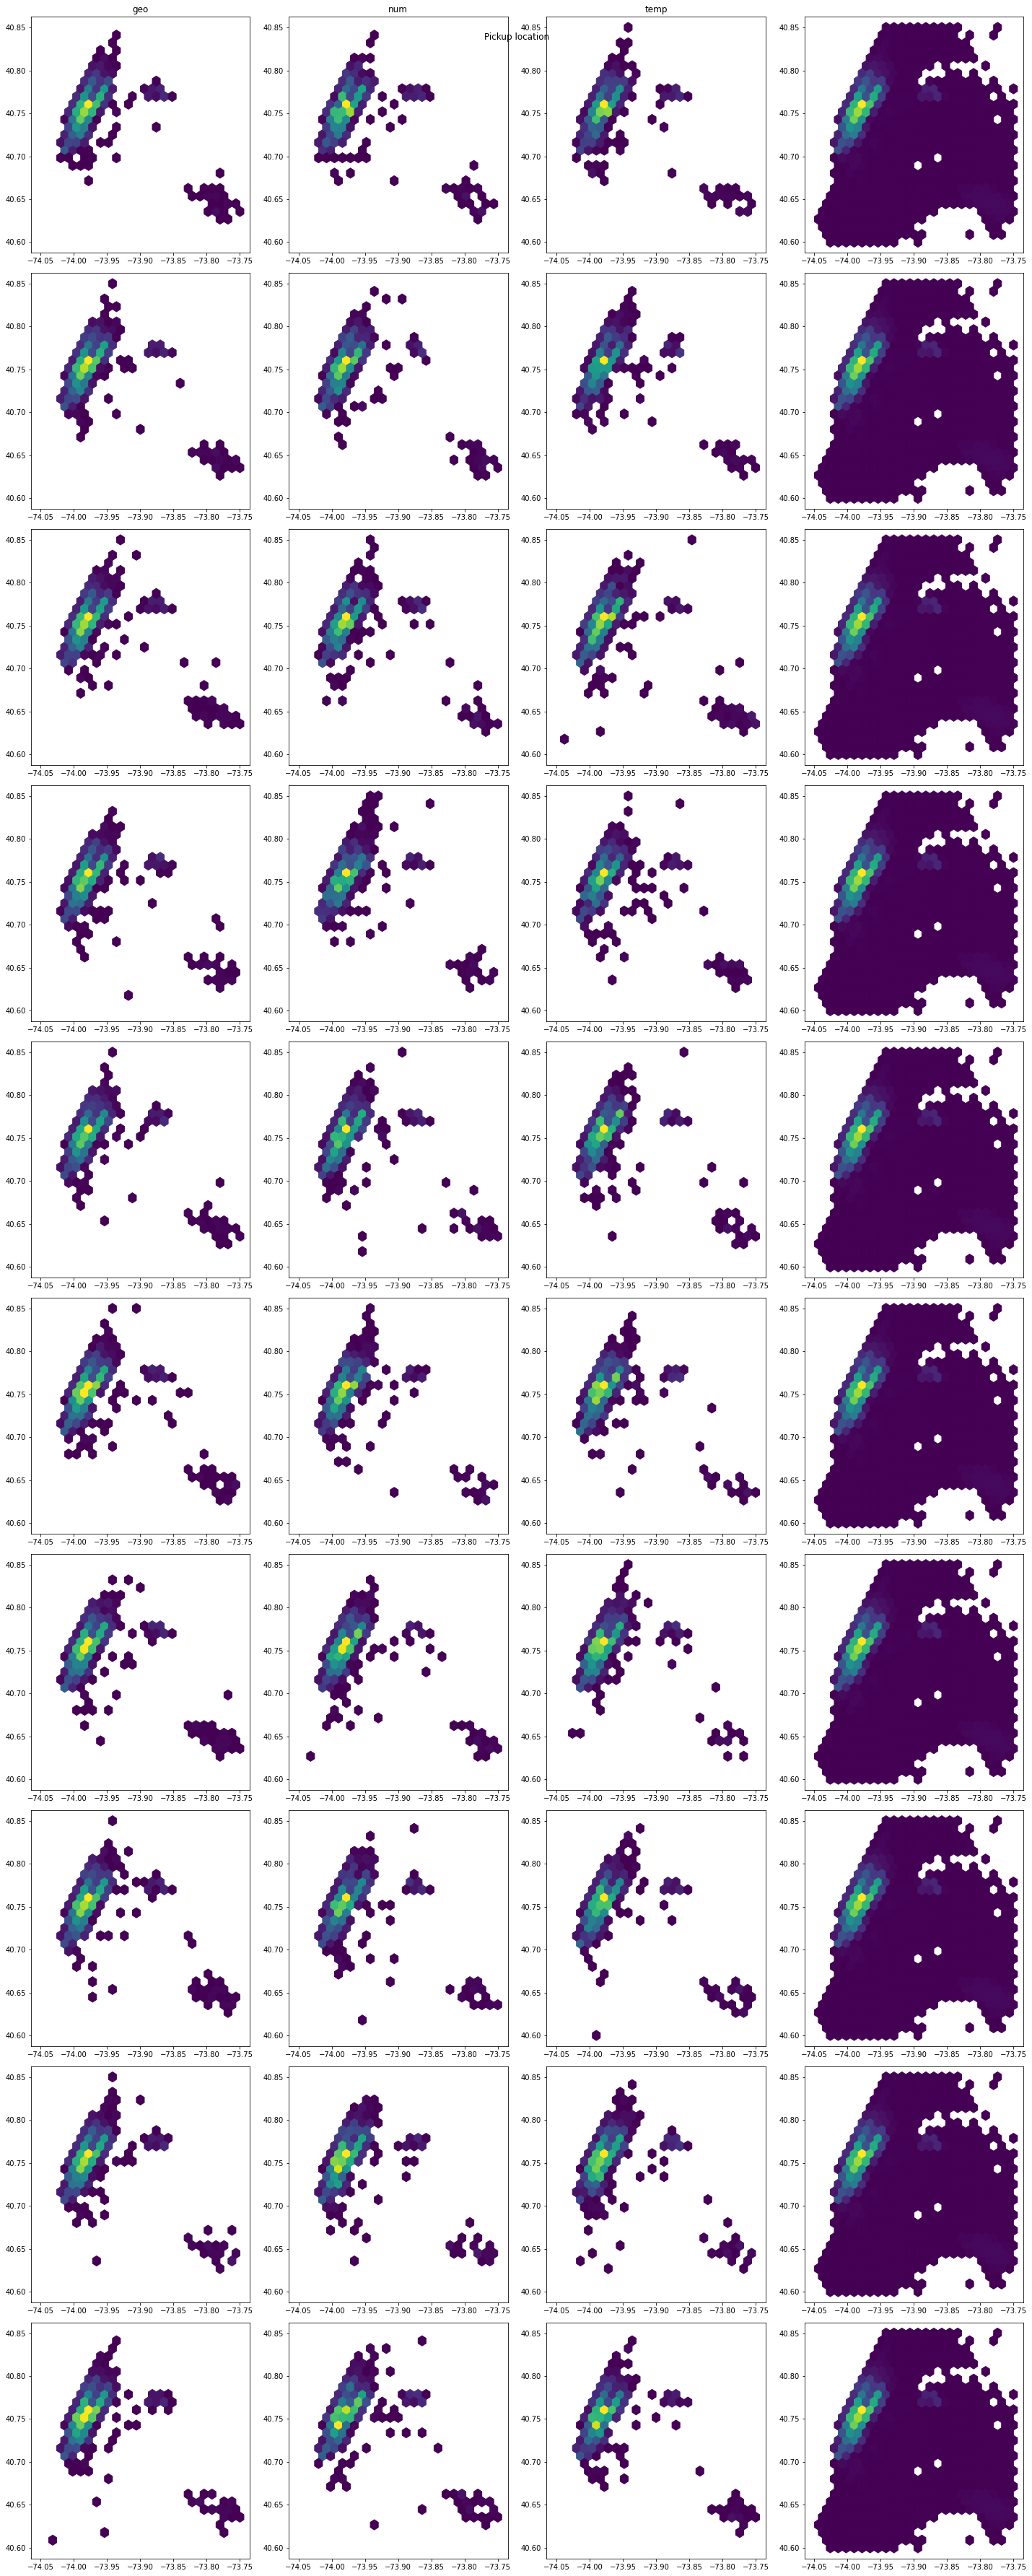

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def geo_hexbin(sample_df: pd.DataFrame, ax: plt):
  return ax.hexbin(
    x=sample_df["PURepresentativeX"], 
    y=sample_df["PURepresentativeY"],
    # bins="log",
    mincnt=1,
    gridsize=25,
    extent=[-74.05, -73.75, 40.6, 40.85]
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]


def plot_geo():
  fig, ax = plt.subplots(n_chunks, 4, figsize=(20, n_chunks * 5))
  fig.suptitle("Pickup location")

  ground_truth_df = pd.DataFrame(pl1.subdivision.linearization, columns=columns)

  for i in range(n_chunks):
    chunk_geo = pd.DataFrame(pl1.get_next_chunk(), columns=columns)
    chunk_num = pd.DataFrame(pl2.get_next_chunk(), columns=columns)
    chunk_temp = pd.DataFrame(pl3.get_next_chunk(), columns=columns)

    geo_hexbin(chunk_geo, ax[i][0])
    geo_hexbin(chunk_num, ax[i][1])
    geo_hexbin(chunk_temp, ax[i][2])
    geo_hexbin(ground_truth_df, ax[i][3])

  for ax_, col in zip(ax[0], ["geo", "num", "temp"]):
    ax_.set_title(col)
  
  plt.tight_layout()
  plt.show()

n_chunks = 10
plot_geo()

A conclusion from this test is that by linearizing along the geospatial attribute, we can ensure a relatively consistent distribution across consecutive chunks. 
Comparing `geo` to the other two classes, we can see that in particular the regions around the two airports La Guardia and JFK, the points in the sparse areas, and the outliers around Manhattan are more consistent.
We get this spatial consistency from the z-order curve.

### Effect of exchanging the subdivision strategy

Below, we demonstrate how exchanging the subdivision strategy allows us to influence the distribution of values in the early chunking:

The pipelines:

In [2]:
import os, sys
sys.path.append(f"{os.getcwd()}/../")

from pipeline.Pipeline import Pipeline

# focus on spatial attributes
config1 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "standard",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [5]  # travel_distance
  }
}

# focus on numerical attributes
config2 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "stratified",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [5]  # travel_distance
  }
}

# focus on temporal attribute
config3 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "representative",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [5],  # travel_distance,
    "k": 1000
  }
}

pl1 = Pipeline(config1)
pl2 = Pipeline(config2)
pl3 = Pipeline(config3)

preprocessing pipeline ...
Done with the pre-processing


distribution per chunk


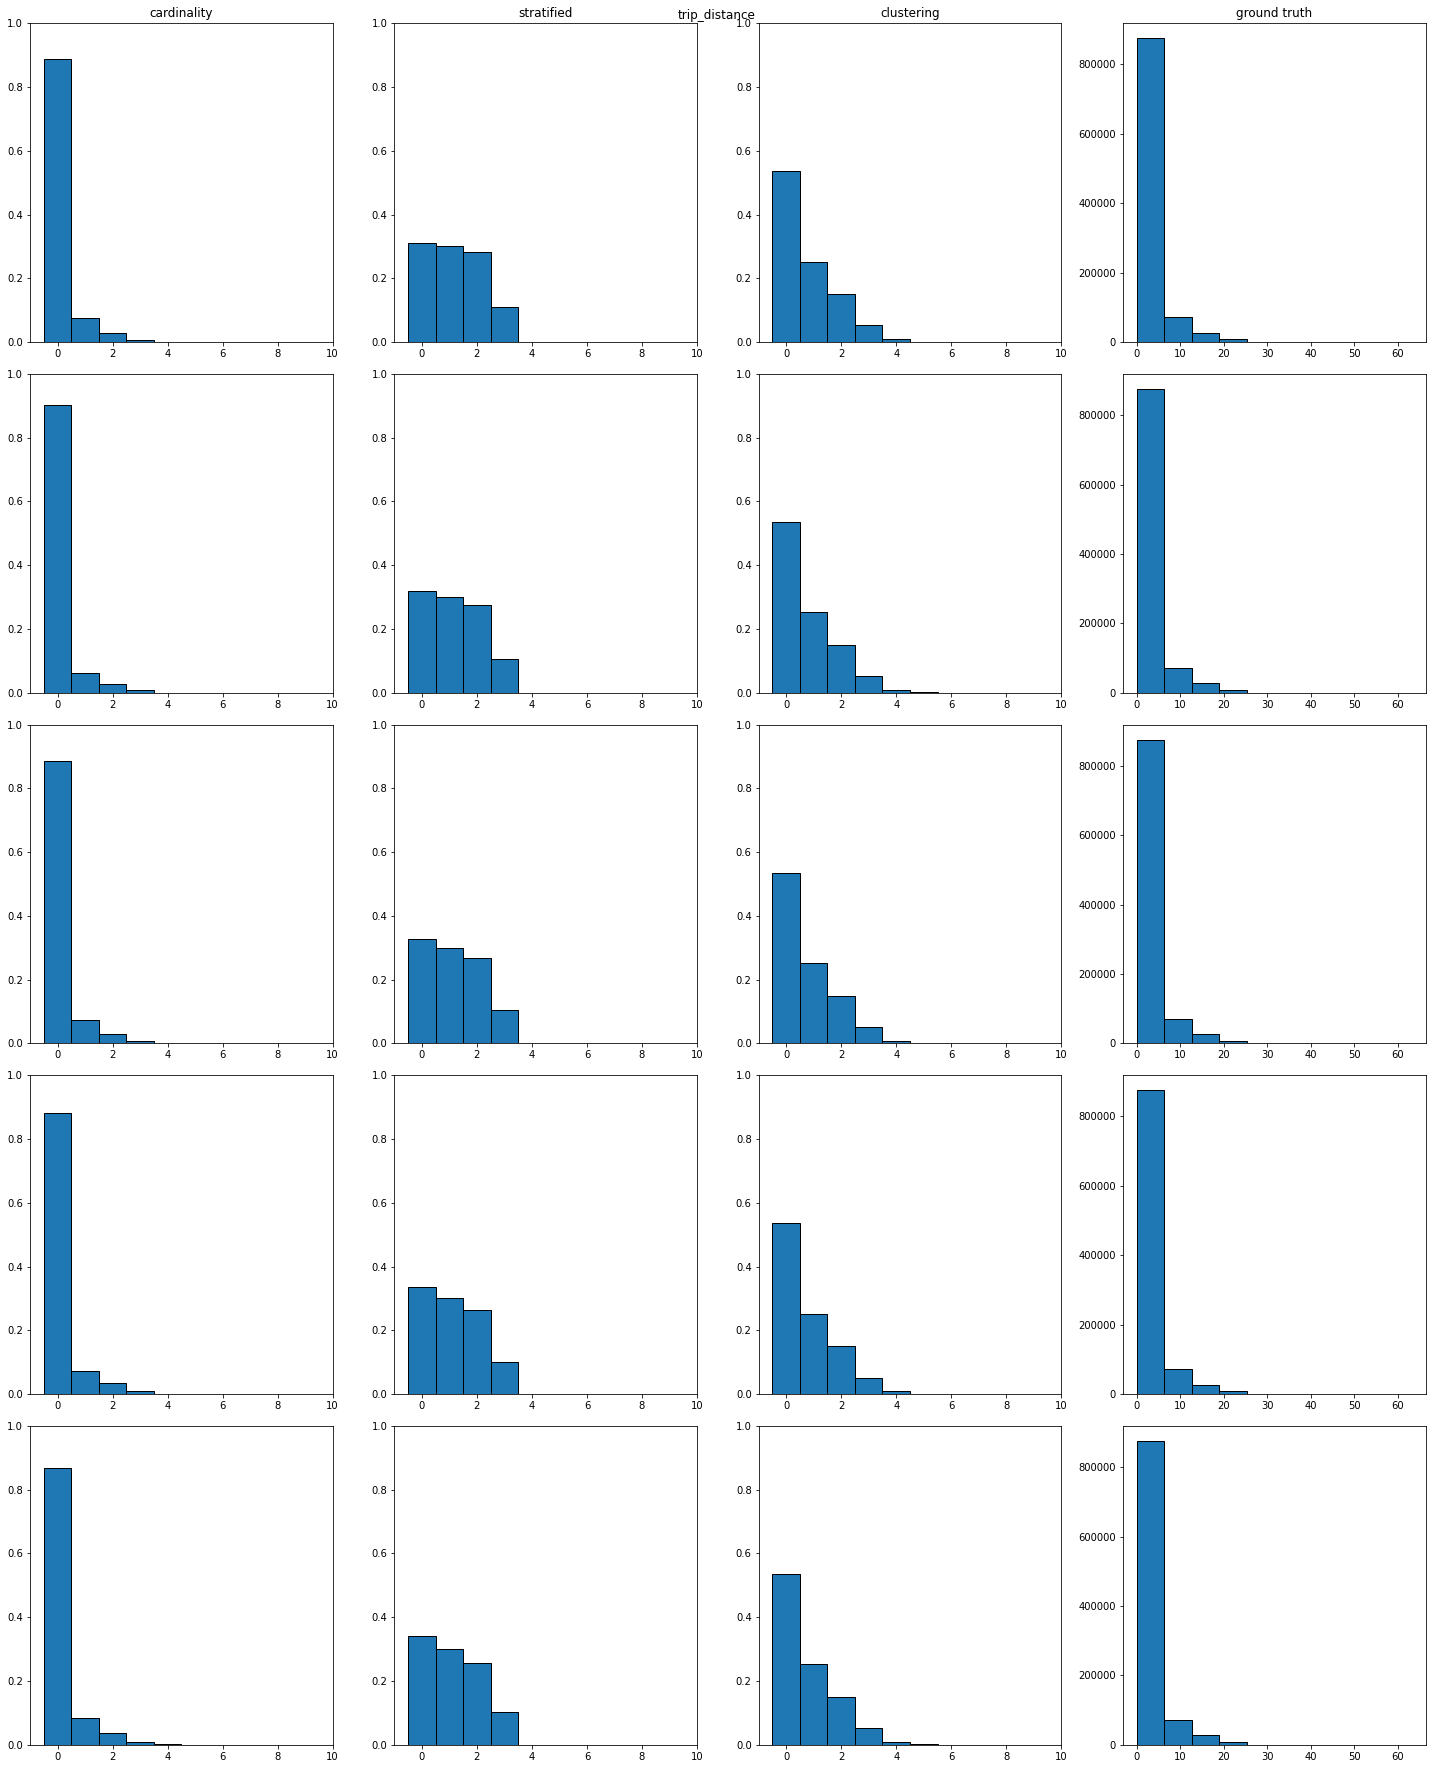

size per bin


<BarContainer object of 985 artists>

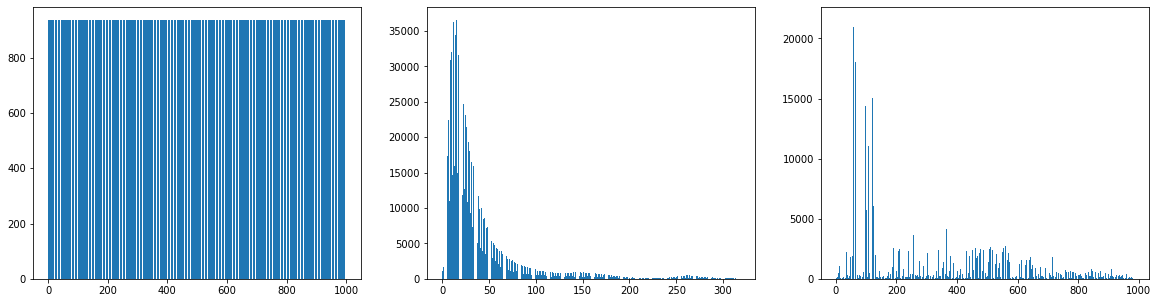

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def scatter(df: pd.DataFrame, range: list[int], ax: plt):
  return ax.scatter(
    x=df[df.columns[0]],
    y=df[df.columns[1]],
  )

def hist(sample_df: pd.Series, value_range: tuple, n_bins, ax: plt):
  return ax.hist(
    sample_df, 
    bins=n_bins,
    range=value_range,
    edgecolor='black', 
    linewidth=1
  )

def delta_hist(delta: pd.Series, ax: plt):
  return ax.bar(
    delta.index,
    delta,
    width=1,
    edgecolor='black', 
    linewidth=1,
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]


def plot_hist(attr: str):
  fig, ax = plt.subplots(n_chunks, 4, figsize=(20, n_chunks * 5))
  fig.suptitle(attr)

  n_bins = 10
  ground_truth_df = pd.DataFrame(pl1.subdivision.linearization, columns=columns)[attr]
  bins = np.linspace(ground_truth_df.min(), ground_truth_df.max(), n_bins+1)  # because arange does not include max

  value_range = [ground_truth_df.min(), ground_truth_df.max()]

  for i in range(n_chunks):
    chunk_cardinality = pd.DataFrame(pl1.get_next_chunk(), columns=columns)[attr]
    chunk_stratified = pd.DataFrame(pl2.get_next_chunk(), columns=columns)[attr]
    chunk_clustering = pd.DataFrame(pl3.get_next_chunk(), columns=columns)[attr]

    for j, df in enumerate([chunk_cardinality, chunk_stratified, chunk_clustering]):
      df_bins = np.histogram(df, bins=bins)[0]
      df_bins = df_bins / df_bins.sum()
      delta_hist(pd.Series(df_bins), ax[i][j])
      ax[i][j].set_ylim(0, 1)
    

    hist(ground_truth_df, value_range, n_bins, ax[i][3])

  for ax_, col in zip(ax[0], ["cardinality", "stratified", "clustering", "ground truth"]):
    ax_.set_title(col)
  
  plt.tight_layout()
  plt.show()

n_chunks = 5
print("distribution per chunk")
plot_hist("trip_distance")


print("size per bin")
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].bar(
  x=np.arange(0, len(list(pl1.selection.subdivision.keys()))), 
  height=np.array([len(pl1.selection.subdivision[s]) for s in pl1.selection.subdivision])
)
ax[1].bar(
  x=np.arange(0, len(list(pl2.selection.subdivision.keys()))), 
  height=np.array([len(pl2.selection.subdivision[s]) for s in pl2.selection.subdivision])
)
ax[2].bar(
  x=np.arange(0, len(list(pl3.selection.subdivision.keys()))), 
  height=np.array([len(pl3.selection.subdivision[s]) for s in pl3.selection.subdivision])
)


### Effect of exchanging the selection strategy on value distributions

Below, we demonstrate the impact of the selection strategy on the retrieved values, comparing four pipelines which vary only in the selection strategy they use.

The pipelines:

In [29]:
import os, sys
sys.path.append(f"{os.getcwd()}/../")

from pipeline.Pipeline import Pipeline

# focus on spatial attributes
config1 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "standard",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [5]  # travel_distance
  }
}

# focus on numerical attributes
config2 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "standard",
  "selection": "first",
  "dimension": 5,
  "params": {
    "subspace": [5]  # travel_distance
  }
}

# focus on temporal attribute
config3 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "standard",
  "selection": "median",
  "dimension": 5,
  "params": {
    "subspace": [5]  # travel_distance
  }
}

# focus on temporal attribute
config4 = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "standard",
  "selection": "maximum",
  "dimension": 5,
  "params": {
    "subspace": [5]  # travel_distance
  }
}

pl1 = Pipeline(config1)
pl2 = Pipeline(config2)
pl3 = Pipeline(config3)
pl4 = Pipeline(config4)

preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing


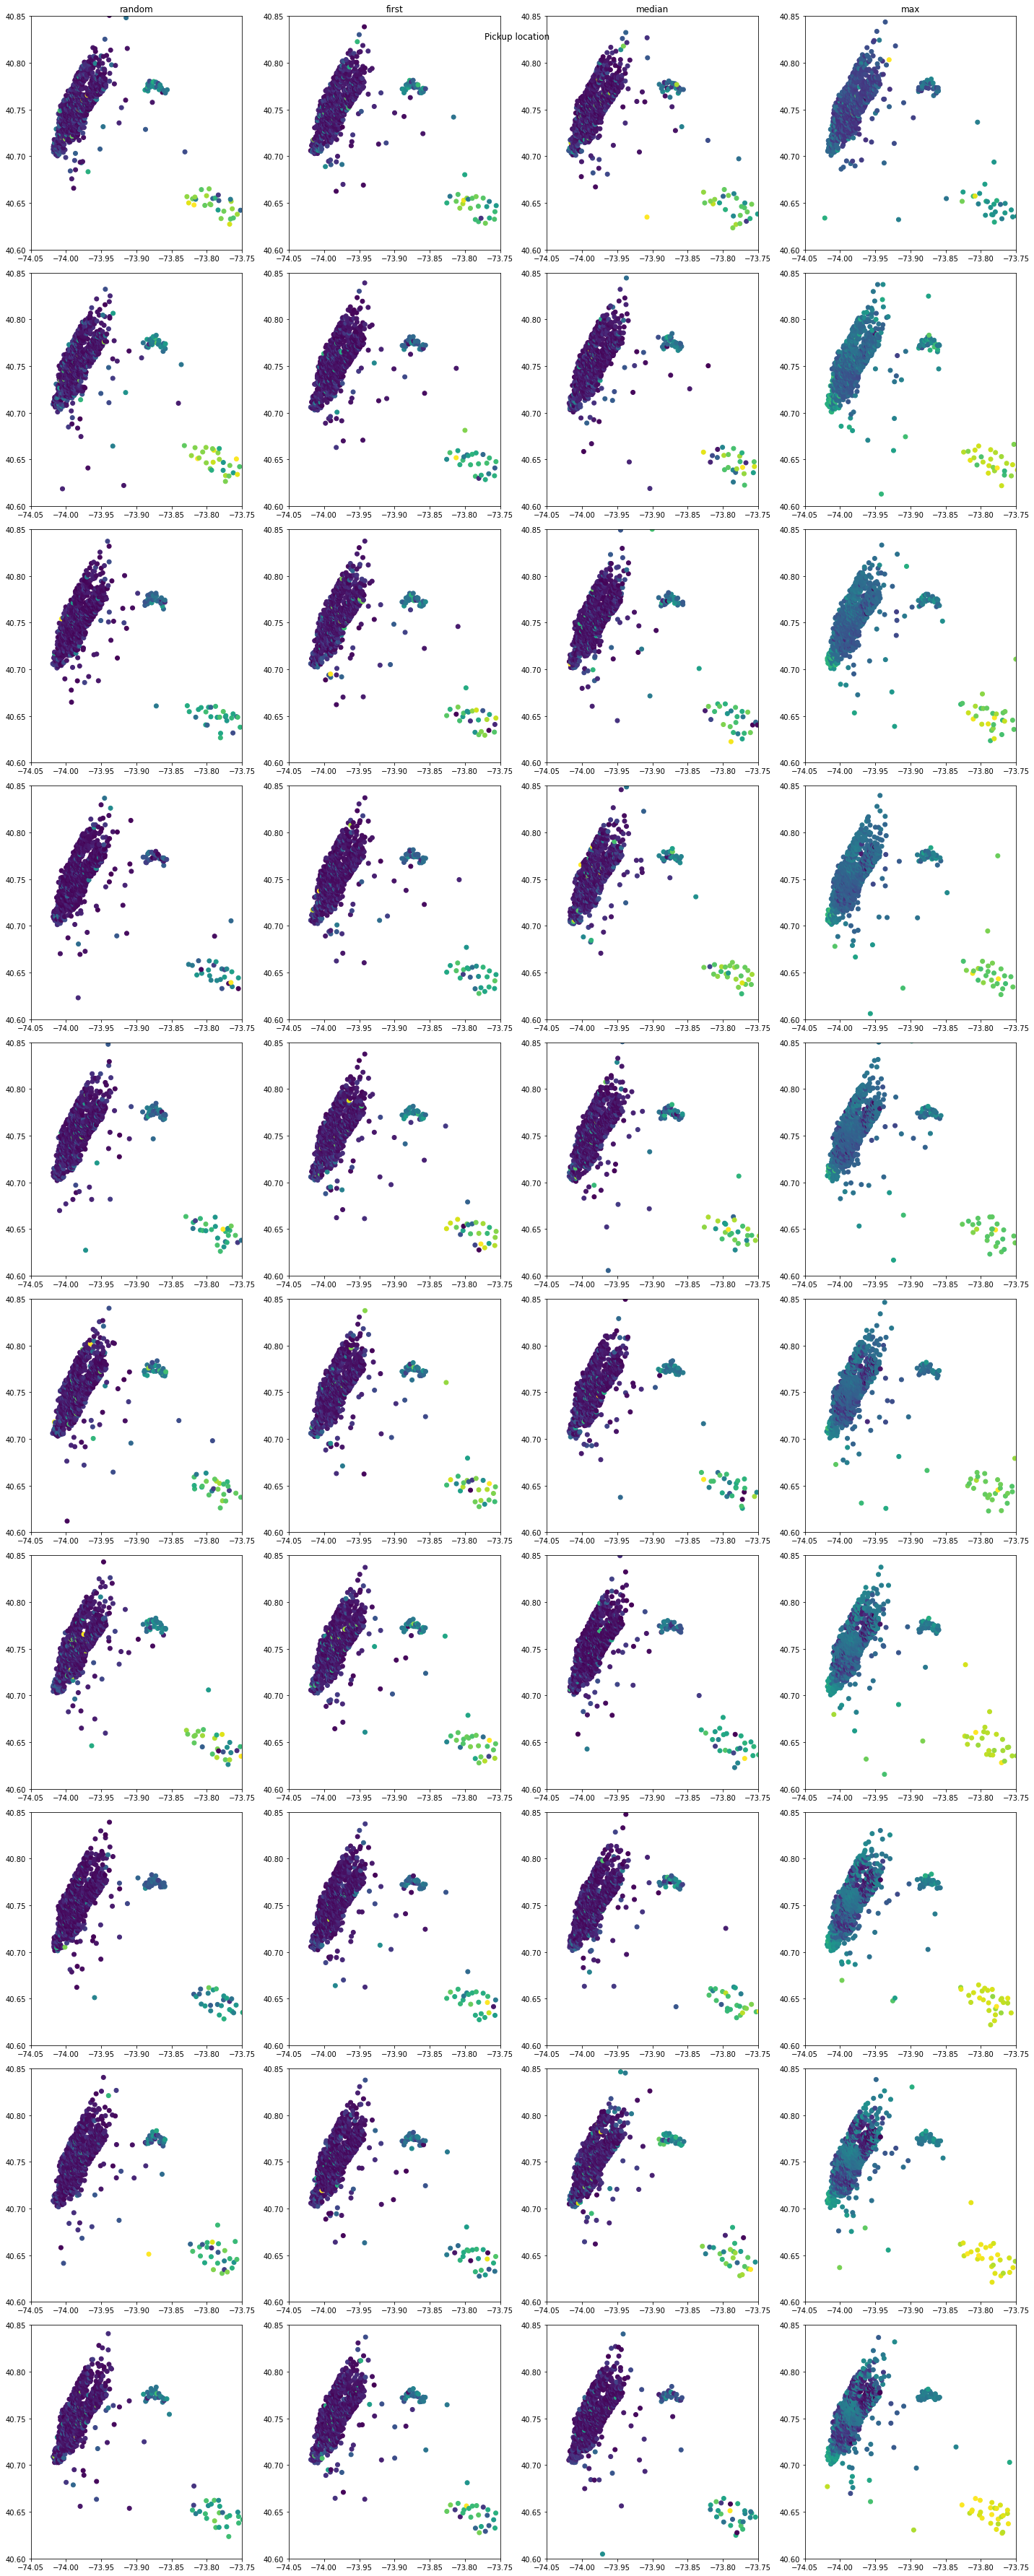

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def geo_scatter(sample_df: pd.DataFrame, ax: plt):
  ax.set_xlim(-74.05, -73.75)
  ax.set_ylim(40.6, 40.85)
  
  return ax.scatter(
    x=sample_df["PURepresentativeX"], 
    y=sample_df["PURepresentativeY"],
    c=sample_df["trip_distance"],
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]


def plot_geo_scatter():
  fig, ax = plt.subplots(n_chunks, 4, figsize=(20, n_chunks * 5))
  fig.suptitle("Pickup location")

  for i in range(n_chunks):
    chunk_random = pd.DataFrame(pl1.get_next_chunk(), columns=columns)
    chunk_first = pd.DataFrame(pl2.get_next_chunk(), columns=columns)
    chunk_median = pd.DataFrame(pl3.get_next_chunk(), columns=columns)
    chunk_max = pd.DataFrame(pl4.get_next_chunk(), columns=columns)

    geo_scatter(chunk_random, ax[i][0])
    geo_scatter(chunk_first, ax[i][1])
    geo_scatter(chunk_median, ax[i][2])
    geo_scatter(chunk_max, ax[i][3])

  for ax_, col in zip(ax[0], ["random", "first", "median", "max"]):
    ax_.set_title(col)
  
  plt.tight_layout()
  plt.show()

n_chunks = 10
plot_geo_scatter()